In [54]:
# credits to: https://keras.io/examples/vision/image_classification_with_vision_transformer/

import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
# from keras import ops
import tensorflow as tf
# from tensorflow import ops

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from keras.models import Sequential
from keras.layers import Rescaling, Resizing

In [55]:
learning_rate = 0.002
weight_decay = 0.0001
batch_size = 512
num_epochs = 30
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    1024,
    512,
]

In [56]:
# Define constants
num_classes = 90
input_shape = (32, 32, 3)

# Define paths
base_dir = 'z3_data/'
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

# Initialize ImageDataGenerators
train_datagen = ImageDataGenerator(validation_split=0.1)
test_datagen = ImageDataGenerator()

# Define the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=1,
    shuffle=True,
    class_mode='sparse',
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=1,
    shuffle=True,
    class_mode='sparse',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='sparse')

# Function to accumulate batches
def accumulate_batches(generator, num_samples):
    batch_count = num_samples // generator.batch_size
    x, y = [], []
    for _ in range(batch_count):
        data_batch, labels_batch = next(generator)
        x.append(data_batch)
        y.append(labels_batch)
    return np.vstack(x), np.vstack(y).reshape(-1, 1)

# Accumulate data
x_train, y_train = accumulate_batches(train_generator, 4860)
x_test, y_test = accumulate_batches(test_generator, 540)

# Output the shapes
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


Found 4410 images belonging to 90 classes.
Found 450 images belonging to 90 classes.
Found 540 images belonging to 90 classes.
x_train shape: (4860, 32, 32, 3) - y_train shape: (4860, 1)
x_test shape: (540, 32, 32, 3) - y_test shape: (540, 1)


In [57]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [58]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [59]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        shape = tf.shape(images)
        batch_size, height, width, channels = shape[0], shape[1], shape[2], shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


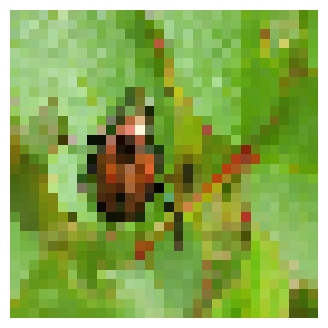

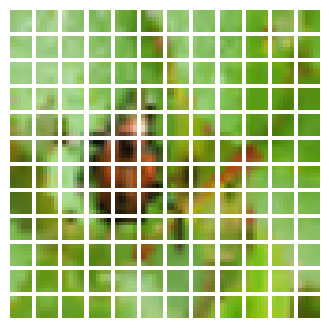

In [60]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [61]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(tf.range(0, self.num_patches, 1), axis=0)
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [62]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes, activation='softmax')(features)
    logits = layers.Dense(num_classes)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/30
9/9 [==============================] - 106s 11s/step - loss: 5.5534 - accuracy: 0.0133 - val_loss: 4.4275 - val_accuracy: 0.0206
Epoch 2/30
9/9 [==============================] - 96s 11s/step - loss: 4.5431 - accuracy: 0.0197 - val_loss: 4.4169 - val_accuracy: 0.0267
Epoch 3/30
9/9 [==============================] - 91s 10s/step - loss: 4.4600 - accuracy: 0.0210 - val_loss: 4.3819 - val_accuracy: 0.0267
Epoch 4/30
9/9 [==============================] - 97s 11s/step - loss: 4.4257 - accuracy: 0.0240 - val_loss: 4.3839 - val_accuracy: 0.0391
Epoch 5/30
9/9 [==============================] - 94s 10s/step - loss: 4.4252 - accuracy: 0.0238 - val_loss: 4.3712 - val_accuracy: 0.0535
Epoch 6/30
9/9 [==============================] - 90s 10s/step - loss: 4.4078 - accuracy: 0.0286 - val_loss: 4.3531 - val_accuracy: 0.0391
Epoch 7/30
9/9 [==============================] - 92s 10s/step - loss: 4.3853 - accuracy: 0.0254 - val_loss: 4.3062 - val_accuracy: 0.0391
Epoch 8/30
9/9 [==========

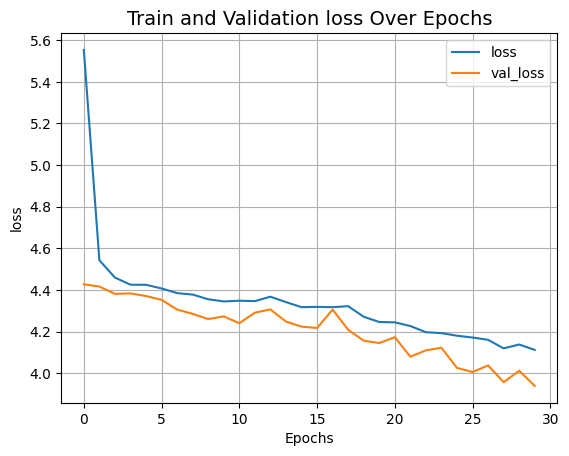

In [63]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # Evaluate the model on the test dataset
    _, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

    # Evaluate the model on the training dataset
    _, train_accuracy = model.evaluate(x_train, y_train)
    print(f"Train accuracy: {round(train_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

In [ ]:
# create confusion matrix
